In [205]:
# 导入ricequant
import os
os.environ["RQDATAC2_CONF"] = "rqdata://license:c9qmzpaiaJ2ZISkX0wjCCypHhcODsOPMeIMPBp-xZcwujI3nkirkvIzie9RGooYOBvg02G0_6RY3-0fGpfBMVVHh2Dk608UfSx71AptxtMHmXjqwbiL0LS03ZEp9Q4AzDfB-cY0aWOhsLrPeJqkVdeGHyMIwMXa6xISmt6tUPsg=VI1TWeRAs6fo-Tz3A8YTOE1gEzOeQkxJSkHWyawl5dMI86NdDkUu617N0fDEOeoFV-6-lzvQkhE5qrf5N8IQpt9vcMTnoSwnnes5aYG6am74w-pporQXanNMH7d3SuBAlGHS_ixnVWZRyVm1YjrAAveqn0fKgJoUVl2x3ga0EK4=@rqdatad-pro.ricequant.com:16011"
# print(os.environ.get("RQDATAC2_CONF"))
import rqdatac as rq
rq.init()

/opt/anaconda3/envs/finmod/lib/python3.10/site-packages/rqdatac/client.py:224: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)


In [206]:
# 导入其他包
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [207]:
# 获取持仓数据
# akshare上的数据只精确到“万”，四舍五入带来的问题严重，故直接从基金2021年年报获取持仓数据

# 股票持仓数据
current_folder = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_folder, ".."))
target_file_path = os.path.join(parent_folder, "data", "中欧时代先锋股票型基金2021年持仓明细.csv")
stock_hold = pd.read_csv(target_file_path, dtype={"股票代码": str})

# 清洗股票持仓数据
stock_hold["股票代码"] = stock_hold["股票代码"].str.zfill(6) # 补全股票代码前导0
stock_hold.set_index("股票代码", inplace=True) # 设置index

# 2021年底仅持0.06%的21国债01，对组合收益影响微乎其微，故直接忽略

In [208]:
stock_hold.head(10)

,序号,股票名称,数量（股）,公允价值（元）,占基金资产净值比例（%）
股票代码,,,,,
002475,1,立讯精密,38631788,1.900684e+09,8.52
002415,2,海康威视,22928442,1.199616e+09,5.37
300454,3,深信服,6258946,1.195459e+09,5.36
300750,4,宁德时代,1998366,1.175039e+09,5.26
300413,5,芒果超媒,17101103,9.571318e+08,4.29
603799,6,华友钴业,7637836,8.425297e+08,3.77
600660,7,福耀玻璃,14535546,6.852056e+08,3.07
002466,8,天齐锂业,5800858,6.206918e+08,2.78
002460,9,赣锋锂业,3738223,5.340052e+08,2.39


In [209]:
# 获取stock_hold的市场数据
stock_codes = stock_hold.index.tolist()

# 给股票代码加上市场归属
def add_market_suffix(code):
    """根据股票代码判断市场，添加对应后缀"""
    if code.startswith(("00", "30")):  # 深市（00开头/30开头）
        return f"{code}.XSHE"
    elif code.startswith(("60", "68")):  # 沪市（60开头/68开头）
        return f"{code}.XSHG"
    else:
        print(f"⚠️  无法识别股票代码 {code} 的市场，跳过该股票")
        return None
    
# 批量添加后缀，过滤无效代码
stock_codes_with_suffix = []
for code in stock_hold.index.tolist():
    suffix_code = add_market_suffix(code)
    if suffix_code:  # 只保留有效代码
        stock_codes_with_suffix.append(suffix_code)

start_date = 20211231
end_date = 20221231
fields = "close"
frequency = "1d"
adjust_type = "pre"

all_stock = rq.get_price(stock_codes_with_suffix, 
                              start_date=start_date, 
                              end_date=end_date, 
                              fields=fields,
                              frequency=frequency, 
                              adjust_type=adjust_type
                              )

# 清洗市场数据
all_stock.reset_index(inplace=True)

# 去掉市场后缀，与stock_hold对应
all_stock["order_book_id"] = (
    all_stock["order_book_id"]
    .astype(str)
    .str.replace(r"\..*", "", regex=True)
)

In [210]:
# 构建价格矩阵、持仓矩阵

# 价格矩阵（日期x股票）
price_matrix = all_stock.pivot_table(
    index = "date",
    columns = "order_book_id",
    values = "close"
)
price_matrix = price_matrix.sort_index()
price_matrix.index = pd.to_datetime(price_matrix.index)

# 处理价格矩阵缺失值
# 一些股票2022开年后才上市，但2021年报中已有持仓（预申购）。使用发行价填充上市前价格
unlisted_stock_info = {
    "001234": {"issue_price": 16.53, "listing_date": "2022-01-11"},
    "301136": {"issue_price": 10.52, "listing_date": "2022-01-11"},
    "688176": {"issue_price": 22.98, "listing_date": "2022-01-07"},
    "688262": {"issue_price": 41.98, "listing_date": "2022-01-06"}
}

for stock_code, info in unlisted_stock_info.items():
    if stock_code in price_matrix.columns:
        listing_date = pd.to_datetime(info["listing_date"])
        issue_price = info["issue_price"]
        
        # 找到上市日期之前的所有日期索引
        # 逻辑：时间 < 上市日期 AND 值为空(NaN)
        mask_date = price_matrix.index < listing_date
        mask_nan = price_matrix[stock_code].isna()
        
        final_mask = mask_date & mask_nan # 取交集：既要是上市前，又要确实是空值的
        
        # 执行填充
        price_matrix.loc[final_mask, stock_code] = issue_price
    else:
        print(f"⚠️ 股票 {stock_code} 不在价格矩阵中，跳过")

# 检查并处理 stock_hold 中的重复索引
# 原始数据里，存在同一只股票被分成了多行记录（例如流通股和受限股分开列示），现在把它们合并
if stock_hold.index.duplicated().any():
    print(f"⚠️ 检测到 {stock_hold.index.duplicated().sum()} 个重复的股票代码，已合并")
    # 对重复的股票代码进行聚合：数值列求和，非数值列取第一个
    stock_hold = stock_hold.groupby(level=0).agg({
        "股票名称": "first",
        "数量（股）": "sum",
        "公允价值（元）": "sum",
        # 其他需要的列也可以在这里加
    })

# 持仓矩阵（股票x持仓股数）

# 在调用价格的时候使用了前复权（将历史价格向下调整，以剔除分红、配股、拆细等对股价走势的“断层”影响，从而保证收益率曲线的连续性）
# 但是，2021年年报中的“持仓市值”是基于2021年12月31日当天的真实收盘价计算的
# 这会导致初始持仓金额对不上

# hold_matrix = stock_hold.pivot_table(
#     index = "股票代码",
#     values = "数量（股）"
# )

price_20211231 = price_matrix.loc['2021-12-31']
real_market_value = stock_hold['公允价值（元）']
simulated_shares = real_market_value / price_20211231

hold_matrix = simulated_shares.reindex(price_matrix.columns).fillna(0)

⚠️ 检测到 3 个重复的股票代码，已合并


In [211]:
# 计算日度回报
simulated_daily_return = price_matrix.dot(hold_matrix).to_frame(name="Stock_Asset") # 矩阵向量乘法

# 持仓Net Value除了股票外，还有债券（占总市值0.06%的国债）、买入返售金融资产、银行存款和结算备付金合计、其他各项资产
# 提取财报中的非股票资产金额 (单位：元)
bond_val = 12955590.60 # 债券 (固定收益投资)
repo_val = 53600000.00 # 买入返售金融资产
cash_val = 2291462062.61 # 银行存款和结算备付金
other_val = 88935241.68 # 其他各项资产
liabilities = 564231252.68 # 总负债
non_equity_sum = bond_val + repo_val + cash_val + other_val - liabilities # 非权益类资产总和

simulated_daily_return["Simulated Net Value"] = simulated_daily_return["Stock_Asset"] + non_equity_sum # 总净值 = 动态的股票市值 + 静态的非股票资产

simulated_daily_return["Simulated Daily Return"] = simulated_daily_return["Simulated Net Value"].pct_change() * 100 # 计算日度收益率

simulated_daily_return.head(5)

,Stock_Asset,Simulated Net Value,Simulated Daily Return
date,,,
2021-12-31,2.043831e+10,2.232103e+10,NaN
2022-01-04,2.017293e+10,2.205565e+10,-1.188923
2022-01-05,1.946432e+10,2.134704e+10,-3.212812
2022-01-06,1.935647e+10,2.123919e+10,-0.505238
2022-01-07,1.904142e+10,2.092414e+10,-1.483328


In [212]:
# 获取2022年基金实际行情数据
order_book_ids = ["001938", "004241"] # 001938：中欧时代先锋股票A；004241：中欧时代先锋股票C
start_date = 20211231
end_date = 20221231
fields = ["unit_net_value", "change_rate"]

daily_return_AC = rq.fund.get_nav(
    order_book_ids=order_book_ids,
    start_date=start_date,
    end_date=end_date,
    fields=fields,
    expect_df=True
)

daily_return_AC = daily_return_AC.reset_index()

daily_return_AC.head(5)

,order_book_id,datetime,unit_net_value,change_rate
0,001938,2021-12-31,1.8666,0.010940
1,001938,2022-01-04,1.8441,-0.012054
2,001938,2022-01-05,1.7838,-0.032699
3,001938,2022-01-06,1.7773,-0.003644
4,001938,2022-01-07,1.7517,-0.014404


In [213]:
# 根据A、C的不同发行份额计算整个“中欧时代先锋股票”的daily return
navs_pivot = daily_return_AC.pivot(
    index = "datetime",
    columns = "order_book_id",
    values = "unit_net_value"
)

share_001938 = 9685321514.86
share_004241 = 2338391846.83

# 计算daily return
asset_A = navs_pivot['001938'] * share_001938
asset_C = navs_pivot['004241'] * share_004241

total_asset = asset_A + asset_C

combined_daily_return = total_asset.pct_change()

real_daily_return = pd.DataFrame({
    "Real Net Value": total_asset,
    "Real Daily Return": combined_daily_return
}).reset_index()

real_daily_return.rename(columns={"datetime": "date"}, inplace=True) # 更改列名，与simulated_daily_return统一

real_daily_return.set_index("date", inplace=True)

real_daily_return.head(5)

,Real Net Value,Real Daily Return
date,,
2021-12-31,2.232117e+10,NaN
2022-01-04,2.205157e+10,-0.012078
2022-01-05,2.133051e+10,-0.032699
2022-01-06,2.125259e+10,-0.003653
2022-01-07,2.094666e+10,-0.014395


In [214]:
# 验证：20211231的净值能跟财报对上
target_date = pd.to_datetime("20211231")

nav_20211231 = real_daily_return.loc[target_date, "Real Net Value"]
real_nav_20211231 = 22321531418.64

difference = nav_20211231 - real_nav_20211231

difference_in_percentage = difference / real_nav_20211231 * 100

print(f"20211231总净值：{nav_20211231:.2f}元")
print(f"2021财报披露净值：22321531418.64 元")
print(f"差异约{difference/10000:.2f}万元，与223亿元的总资产相比仅为{difference_in_percentage:.4f}%，可以忽略")

20211231总净值：22321165467.34元
2021财报披露净值：22321531418.64 元
差异约-36.60万元，与223亿元的总资产相比仅为-0.0016%，可以忽略


===== 业绩表现对比 =====
             累计收益     年化收益    年化波动     最大回撤     夏普比率
模拟组合(静态)  -26.98%  -27.64%  24.21%  -34.18%  -1.2244
真实基金(动态)  -25.75%  -26.38%  25.16%  -35.04%  -1.1278

基金经理日度跑赢模拟组合的概率 (真实跑赢模拟的天数占比): 51.03%


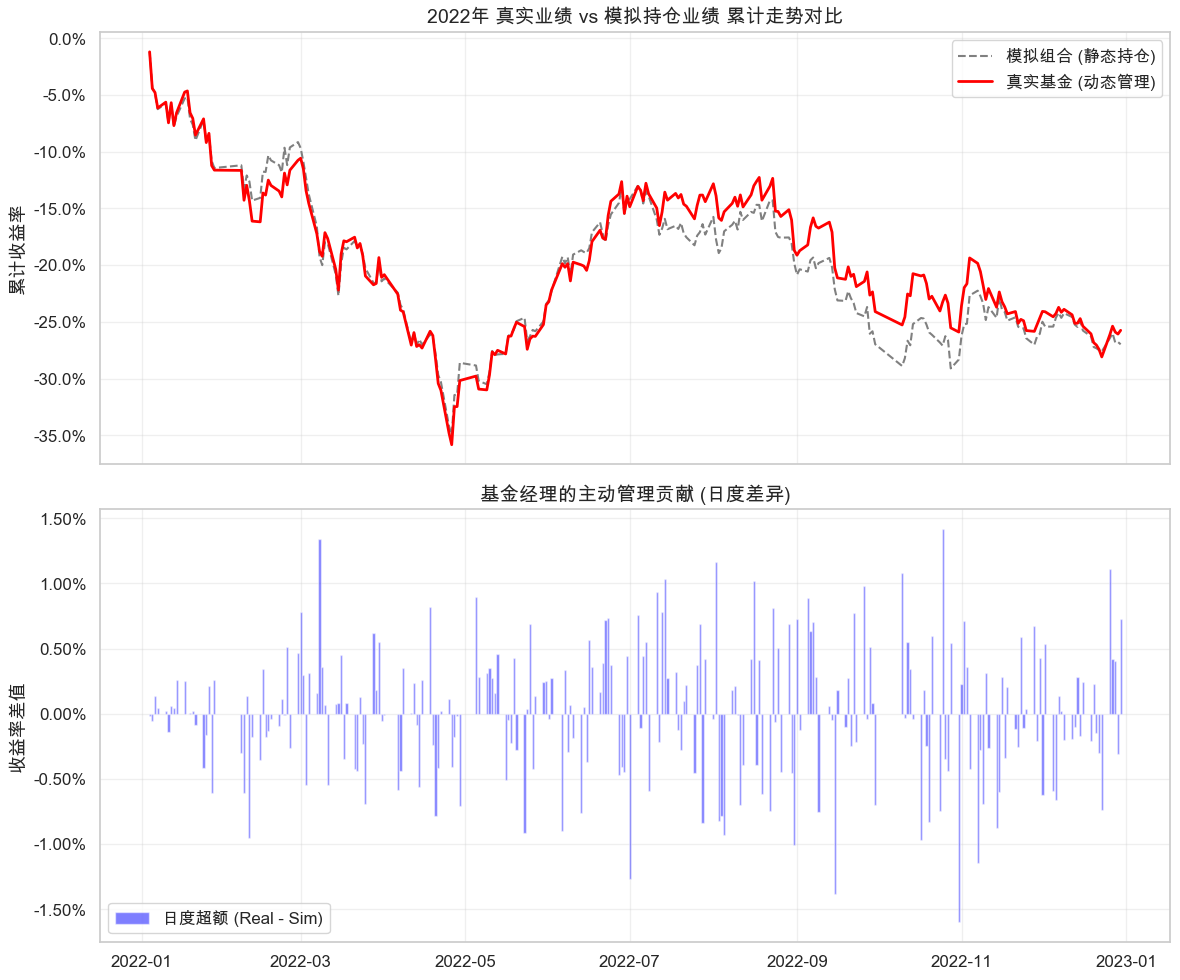

In [215]:
# ==========================================
# 1. 数据准备与对齐
# ==========================================
# 确保索引都是 datetime 类型
simulated_daily_return.index = pd.to_datetime(simulated_daily_return.index)
real_daily_return.index = pd.to_datetime(real_daily_return.index)

# 合并数据 (Inner Join 确保日期一致)
# 注意：您的代码中 simulated 是百分数(*100)，real 是小数(pct_change)，这里统一转换为“小数”
comparison_df = pd.merge(
    simulated_daily_return[["Simulated Daily Return"]],
    real_daily_return[["Real Daily Return"]],
    left_index=True,
    right_index=True
)

# 统一单位：将模拟组合的百分数转回小数
comparison_df["Ret_Sim"] = comparison_df["Simulated Daily Return"] / 100
comparison_df["Ret_Real"] = comparison_df["Real Daily Return"]

# 计算“主动管理带来的超额收益” (Real - Sim)
comparison_df["Active_Return"] = comparison_df["Ret_Real"] - comparison_df["Ret_Sim"]

# ==========================================
# 2. 计算核心指标
# ==========================================
def calculate_metrics(series):
    # 累计收益
    cum_ret = (1 + series).cumprod().iloc[-1] - 1
    # 年化收益 (假设250个交易日)
    ann_ret = (1 + series).prod() ** (250 / len(series)) - 1
    # 年化波动率
    ann_vol = series.std() * np.sqrt(250)
    # 最大回撤
    cum_series = (1 + series).cumprod()
    max_drawdown = (cum_series / cum_series.cummax() - 1).min()
    # 夏普比率 (假设无风险利率为0，简化计算)
    sharpe = (ann_ret - 0.02) / ann_vol # 假设年化无风险利率2%
    
    return {
        "累计收益": f"{cum_ret:.2%}",
        "年化收益": f"{ann_ret:.2%}",
        "年化波动": f"{ann_vol:.2%}",
        "最大回撤": f"{max_drawdown:.2%}",
        "夏普比率": f"{sharpe:.4f}"
    }

metrics_sim = calculate_metrics(comparison_df["Ret_Sim"])
metrics_real = calculate_metrics(comparison_df["Ret_Real"])

# 展示指标对比表
metrics_df = pd.DataFrame([metrics_sim, metrics_real], index=["模拟组合(静态)", "真实基金(动态)"])
print("===== 业绩表现对比 =====")
print(metrics_df)

# 计算胜率 (真实跑赢模拟的天数占比)
win_rate = (comparison_df["Active_Return"] > 0).mean()
print(f"\n基金经理日度跑赢模拟组合的概率 (真实跑赢模拟的天数占比): {win_rate:.2%}")

# ==========================================
# 3. 可视化绘图
# ==========================================
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # 防止中文乱码 (MacOS用Arial Unicode MS, Windows用SimHei)
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 图1：累计收益率曲线
cum_returns = (1 + comparison_df[["Ret_Sim", "Ret_Real"]]).cumprod() - 1
ax[0].plot(cum_returns.index, cum_returns["Ret_Sim"], label="模拟组合 (静态持仓)", color='gray', linestyle='--')
ax[0].plot(cum_returns.index, cum_returns["Ret_Real"], label="真实基金 (动态管理)", color='red', linewidth=2)
ax[0].set_title("2022年 真实业绩 vs 模拟持仓业绩 累计走势对比", fontsize=14)
ax[0].set_ylabel("累计收益率")
ax[0].legend()
ax[0].grid(True, alpha=0.3)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# 图2：主动管理差异 (Real - Sim)
# 正值代表当天基金经理通过调仓跑赢了静态持仓
ax[1].bar(comparison_df.index, comparison_df["Active_Return"], color='blue', alpha=0.5, label="日度超额 (Real - Sim)")
ax[1].set_title("基金经理的主动管理贡献 (日度差异)", fontsize=14)
ax[1].set_ylabel("收益率差值")
ax[1].legend()
ax[1].grid(True, alpha=0.3)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()